## 라이브러리 불러오기

In [1]:
# API 호출
# ## https://data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15057440
from urllib.request import Request, urlopen
# Request https://docs.python.org/ko/3/library/urllib.request.html#urllib.request.Request
# urlopen https://docs.python.org/ko/3/library/urllib.request.html#urllib.request.urlopen
from urllib.parse import urlencode, quote_plus
# urlenocde https://docs.python.org/ko/3/library/urllib.parse.html#urllib.parse.urlencode
# quote_plus https://docs.python.org/ko/3/library/urllib.parse.html#urllib.parse.quote_plus
from urllib.parse import unquote
import requests

# 시간 생성
import time
import datetime
from pytz import timezone, utc

# 폴더 자동 생성
import os

# 코드 스케줄링
import threading
# import schedule

# XML 파싱
import xml.etree.ElementTree as ET

# 입력데이터 데이터프레임 작성
import pandas as pd
import numpy as np

# DataFrame 화면 출력                                                # DataFrame 화면 출력 설정이 변경되어 있습니다 #
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None # default = 60

#EXCEL
import openpyxl

# 배차간격 확인 scatter plot 출력
import matplotlib.pyplot as plt

In [2]:
# 폴더 자동 생성 함수
# https://data-make.tistory.com/170
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

## 기본값 설정하기

In [3]:
def todayStr(year:int, month:int, day:int) -> str:
    todayDateTimeStr = f"{year}-{month}-{day}"
    return todayDateTimeStr

## Key Unquote

In [4]:
KEY = 'yEaR%2F3MDedRSlVJL%2F2pxnVg0yre1N5VF3RZ%2FUAt56MJ7J2mNpfqhUvy05pXV0uhHTVY7DbyCR8xmMaDdYga67Q%3D%3D' # 종현
apiKey = unquote(KEY)

## API 호출

In [5]:
"""
노선정보항목조회 busrouteservice/info
routeId의 정류장 목록을 받아옵니다.
"""
def apiInfo(routeId):
    url = 'http://openapi.gbis.go.kr/ws/rest/busrouteservice/station'
    queryParams = '?' + urlencode({ quote_plus('serviceKey') : apiKey, quote_plus('routeId') : routeId })
    request = Request(url + queryParams)
    request.get_method = lambda: 'GET'

    # API를 호출하여 XML 형식으로 된 string 데이터를 변수 "oneLineXML" 에 저장합니다.
    oneLineXML = urlopen(request).read().decode('utf8')
    return oneLineXML

## XML 파싱

In [6]:
def makeInfoDf(oneLineXML:str):
    # xtree는 "openapi" 도메인 API 호출에서 "headerCd"에 상관없이 3개의 태그를 갖습니다.
    # [comMsgHeader, msgHeader, msgBody]
    xtree = ET.fromstring(oneLineXML)
    # for branch in xtree:
    #     print(branch)
    msgBody = xtree[2]

    tagList = ["stationSeq", "stationId", "stationName", "x", "y"]
    stationList = []
    for branch in msgBody:
        stationList.append([branch.find(tag).text for tag in tagList])

    # station_df의 index가 0부터 시작하는 문제를 해결 하기 위해 rangeIndex를 지정하였습니다.
    stationCount = len(stationList) # 뒤에서 다시 사용되므로 함수로 선언시 주의
    rangeIndex = pd.RangeIndex(start=1, stop=stationCount+1)

    station_df = pd.DataFrame(stationList, columns=tagList, index=rangeIndex)
    station_df = station_df.astype({
        "stationSeq" : "int32",
        "stationId" : "int32", 
        "stationName" : "string",
        "x" : "float",
        "y" : "float"

    })
    return station_df

In [7]:
'''폴더 안에 존재하는 모든(하위 폴더까지 포함) 파일의 경로를 리스트로 반환'''
def allFilePath(routeIdFolder):
    fileList = []
    for root, dirs, files in os.walk(routeIdFolder):
        for fname in files:
            full_fname = os.path.join(root, fname)
            fileList.append(full_fname)
    return fileList

## 데이터 불러오기

In [8]:
'''AWS/Data/daily-time-table폴더에 노선ID(routeId)별로 저장되어 있는 
    텍스트파일(API호출 데이터)의 경로를 존재여부에 상관없이 반환합니다.'''
def getFilePath(routeId, year, month, day):
    curRootDir = os.getcwd()

    subDir = '/AWS/DATA/daily-time-table/'

    strRouteId = str(routeId)
    routeIdFolder = curRootDir + subDir + strRouteId

    fileName = '/' + str(year) + '-' + str(month) + '-' + str(day) + '.txt'

    fileDir = routeIdFolder + fileName
    
    return fileDir

assert getFilePath(204000046, 2020, 12, 23) == '/home/ubuntu/Data-Structure-Project/AWS/DATA/daily-time-table/204000046/2020-12-23.txt'

In [9]:
def rawDf(routeId, year, month, day):
    '''
    routeId 별 정류소 도착시간을 나타내는 2차원 배열을 생성 할 수 있습니다
    마지막 정류소 번호가 필요합니다 : 경유정류소목록조회 API 서비스를 이용하여 가져옵니다.
    중간 또는 처음과 끝에 발생하는 결측치를 채워야 합니다.
    '''
    inputPath = getFilePath(routeId, year, month, day)

    itemTagList = ['DateTime', 'endBus', 'lowPlate', 'plateNo', 'plateType', 'remainSeatCnt', 'routeId', 'stationId', 'stationSeq', 'Nan']
    _raw_df = pd.read_csv(inputPath, sep=' ', skiprows=[0], names=itemTagList)
    _raw_df = _raw_df.drop(["Nan"], axis=1)

    _sorted_df = _raw_df.sort_values(['plateNo'])

    _df = _sorted_df.dropna()

    # string을 datetime객체로 변환하기
    _df['DateTime'] = pd.to_datetime(_df['DateTime'])

    _df = _df.astype({
        'endBus': 'int32', 
        'lowPlate': 'int32', 
        'plateNo': 'string', 
        'plateType': 'int32',
        'remainSeatCnt': 'int32', 
        'routeId': 'int32', 
        'stationId': 'int32', 
        'stationSeq': 'int32'
    })

    return _df

In [10]:
def makePlateNoList(_df):
    # 차량 운행기록을 "plateNo"를 기준으로 구분합니다.
    plateNoList = _df.groupby(['plateNo']).size().index
    return plateNoList

In [11]:
def testPlateNo(plateNo):
    # 차량 번호 한개에 대해서 검사를 실행합니다.
    temp_df =_df[_df['plateNo']==plateNo].sort_values(by='DateTime').reset_index(drop=True)
    tempIndexList = []
    for i in range(1, len(temp_df)):
        if(temp_df.iloc[i-1]['stationSeq'] > temp_df.iloc[i]['stationSeq']):
                tempIndexList.append(i)
                print((temp_df.iloc[i-1]['stationSeq'] , temp_df.iloc[i]['stationSeq']))
                print(i)

        tempIndexList.append(len(temp_df))
    # display(temp_df)
    return temp_df

In [12]:
def initDf(station_df):
    # 정류장의 수 만큼 행을 갖는 빈 데이터프레임을 생성합니다. 
    rangeIndex = station_df.index
    _oneDay_df = pd.DataFrame(index = rangeIndex)
    return _oneDay_df

In [13]:
def makeRangeIndex(station_df):
    return station_df.index

In [14]:
def dropDupDf(_df, plateNoList, station_df):
    _oneDay_df = initDf(station_df)
    # 각 차량 번호를 기준으로 반복문을 수행합니다.
    for plateNo in plateNoList:

        '''특정 차량번호와 같은(_df['plateNo'] == plateNo) 운행기록을 
           DateTime을 기준으로 오름차순으로 정렬(sort_values(['DateTime']합니다.'''
        samebus_df = pd.DataFrame()
        sameBus_df = _df[_df['plateNo'] == plateNo].sort_values(['DateTime']).reset_index(drop=True)

        '''버스는 뒤로가지 않으므로 "stationSeq"가 작아지는 인덱스 i의 리스트를 만듭니다.
           API 호출 오류로 stationSeq가 작아지는 경우가 있습니다. 이 문제를 해결하기 위해 보정계수 diff를 둡니다. 
           diff는 노선의 정류장의 총 개수(rangeIndex.stop)에 일정비율(diffRate)을 곱하여 정의합니다.'''
        indexList = []
        diffRate = 0.8
        isUsingDiff = True
        diff = rangeIndex.stop * diffRate if ( isUsingDiff ) else 0
        for i in range(1,len(sameBus_df)):
            if(sameBus_df.iloc[i-1]['stationSeq'] > sameBus_df.iloc[i]['stationSeq'] + diff ):
                indexList.append(i)
                #print((sameBus_df.iloc[i-1]['stationSeq'] , sameBus_df.iloc[i]['stationSeq']))

        indexList.append(len(sameBus_df))
        #print(plateNo, indexList)


        # 첫번재 인덱스, 인덱스의 리스트, 마지막 인덱스를 조합하여 호차별로 운행기록을 구분합니다.
        index = 0
        #tupleList = []
        for i in indexList:
            #tupleList.append((index, i))
            small_df = sameBus_df.iloc[index:i].groupby(by=['stationSeq']).min()

            # 정류소 데이터프레임에 합칩니다.
            merge_df = pd.merge(station_df, small_df, how='outer', on='stationId')
            # merge_df = merge_df.set_index(keys='stationSeq')

            _oneDay_df[str(plateNo)+'_'+str(index)] = merge_df['DateTime']
            index=i

    return _oneDay_df

In [15]:
def dropNullCol(_oneDay_df):
    #모든 행이 NULL인 열의 인덱스를 리스트 'nullColList'에 저장합니다.
    nullColList = []
    for colIdx, nullCnt in enumerate(_oneDay_df.isnull().sum(axis=0)):
        stationCnt = station_df.index.stop-1
        if(nullCnt == stationCnt):
            nullColList.append(colIdx)
    # /print nullColList

    nullColumnNameList = []
    for colIndex in nullColList:
        nullColumnNameList.append(_oneDay_df.columns[colIndex])
    # /print nullColumnNameList

    for nullColumnName in nullColumnNameList:
    #     /print nullColumnName
        _oneDay_df.drop(columns=[nullColumnName], inplace=True)
    
    temp_df = _oneDay_df.copy()
    
    return temp_df

In [16]:
def get_full_data_index(_temp_df):
    '''
    함수 [get_full_data_index(df)]은 데이터프레임 안에서 결측치가 하나도 없는 행의 index를 반환합니다.
    시간표를 배차 시간순으로 정렬하기 위해 데이터프레임의 첫번째 행을 기준으로 열(axis=1)을 정렬합니다.
    하지만 데이터프레임의 첫번째 행을 기준으로 정렬을 하게되면 결측치로 인하여 정렬이 안되는 열이 발생합니다.
    결측치가 없는 행을 찾기 위해 제작한 함수 입니다.
    모든 행에 결측치가 존재하면 -1을 반환합니다.
    '''
    for i in _temp_df.index:
        nullCountSum = int(_temp_df[i-1:i].isnull().sum(axis=1))
        if nullCountSum == 0:
            return i
    #print("모든 행에 결측치가 존재합니다.")    
    return -1

In [17]:
def sortedCol(_oneDay_df):
    # ISSUE* 모든행에 결측치가 존재할때, if(lineIndex == -1), 예외처리가 필요합니다.
    '''
    예외 처리 방법
    DatatFrame.fillna 메소드를 이용하여 결측치를 1회 채운다음
    다시 함수 'get_full_data_index'를 호출한다.
    단, 결측치를 처리한 데이터프레임에선 정렬 기준(columns)만 취한다.
    + 결측치가 없는 두개의 행을 비교하여 순서가 같은지 검정한다. (기능 추가필요)
    '''
    temp_df = _oneDay_df.copy()
    lineIndex = -1
    fillnaCnt = 0
    i = 0
    while(lineIndex < 0):
        i += 1
        lineIndex = get_full_data_index(temp_df)    
        temp_df.fillna(method='bfill', limit=1, inplace = True)

    '''
    결측치가 하나도 없는 행(lineIndex)를 기준으로 데이터프레임의 열(columns)를 정렬한다.
    정렬 후 데이터 프레임의 열의 순서를 변수 'sortedDfColumns' 리스트에 저장한다.
    정렬된 컬럼 리스트로 _oneDay_df를 정렬하고 이를 oneDay_df에 저장한다.
    '''
    sortedDfColumns = temp_df.sort_values(by=lineIndex, axis=1).columns
    print("함수를 {:2d}번 호출하였습니다. 정렬기준: {:2d}".format(i, lineIndex))

    return sortedDfColumns

### 노선ID(routeId)별 정류소정보 DataFrame

In [18]:
routeId = 204000046
year = 2020
month = 12
day = 28

In [19]:
todayDateTimeStr = todayStr(year, month, day)
outputFileName = todayDateTimeStr + '.csv'
oneLineXML = apiInfo(routeId)
station_df = makeInfoDf(oneLineXML)
rangeIndex = makeRangeIndex(station_df)

In [20]:
outputFolderPath = os.getcwd() + '/out/' + str(routeId) + '/'
createFolder(outputFolderPath)
outputFilePath = outputFolderPath + outputFileName

### 날짜별 로우데이터(raw-data) DataFrame

In [21]:
"""
_df >>> _dropDup_df >>> _dropNull_df >>> oneDay_df

"""
# raw data, not time table.
_df = rawDf(routeId, year, month, day)
plateNoList = makePlateNoList(_df)

# drop dupolicate data, time table...
_dropDup_df =  dropDupDf(_df, plateNoList, station_df)

# drop whole-Null Column
_dropNull_df = dropNullCol(_dropDup_df)

# sorting DataFrame with sorted DataFrame Columns List which is from fillna-ed DataFrame
sortedDfColumns = sortedCol(_dropNull_df)
oneDay_df = _dropNull_df[sortedDfColumns].copy()

함수를  1번 호출하였습니다. 정렬기준: 14


### 최종 데이터프레임을 csv확장자 파일로 출력

In [22]:
oneDay_df.to_csv(outputFilePath, index=False, date_format='%Y-%m-%d %H:%M%S')

### csv파일에 저장된 데이터를 datetime 형식으로 변환하여 데이터프레임에 저장

In [23]:
'''
to_datetime Value Error: at least that [year, month, day] must be specified Pandas
https://stackoverflow.com/questions/39992411/to-datetime-value-error-at-least-that-year-month-day-must-be-specified-pand/39992541#39992541
'''
df = pd.read_csv(outputFilePath, parse_dates=True)
/print outputFilePath
df = pd.to_datetime(df.stack(), format='%Y-%m-%d %H:%M%S').unstack()
# df.dtypes

/home/ubuntu/Data-Structure-Project/out/204000046/2020-12-28.csv


## 여러 날짜의 출차기록을 데이터프레임으로 출력한다

In [24]:
dayList = [28, 29, 30, 31]
for _day in dayList:
    _todayDateTimeStr = todayStr(year, month, _day)
    outputFileName = _todayDateTimeStr + '.csv'
    
    outputFolderPath = os.getcwd() + '/out/' + str(routeId) + '/'
    createFolder(outputFolderPath)
    outputFilePath = outputFolderPath + outputFileName
    
    #/print outputFilePath
    iter_df = pd.read_csv(outputFilePath)
    #display(df.iloc[1:2])

### * SCIPY-curve_fit: Extrapolating Pandas DataFrames
https://stackoverflow.com/questions/22491628/extrapolate-values-in-pandas-dataframe

In [25]:
# !pip3 install scipy

In [26]:
import pandas as pd
# from cStringIO import StringIO
from io import StringIO
from scipy.optimize import curve_fit

In [27]:
_test_df = pd.read_table(StringIO('''
                neg       neu       pos       avg
    0           NaN       NaN       NaN       NaN
    250    0.508475  0.527027  0.641292  0.558931
    500         NaN       NaN       NaN       NaN
    1000   0.650000  0.571429  0.653983  0.625137
    2000        NaN       NaN       NaN       NaN
    3000   0.619718  0.663158  0.665468  0.649448
    4000        NaN       NaN       NaN       NaN
    6000        NaN       NaN       NaN       NaN
    8000        NaN       NaN       NaN       NaN
    10000       NaN       NaN       NaN       NaN
    20000       NaN       NaN       NaN       NaN
    30000       NaN       NaN       NaN       NaN
    50000       NaN       NaN       NaN       NaN'''), sep='\s+')

In [28]:
# Do the original interpolation
_test_df.interpolate(xis=0, inplace=True, limit_area='inside')

In [29]:
# Display result
print ('Interpolated data:')
display (_test_df)

Interpolated data:


,neg,neu,pos,avg
0,NaN,NaN,NaN,NaN
250,0.508475,0.527027,0.641292,0.558931
500,0.579238,0.549228,0.647637,0.592034
1000,0.650000,0.571429,0.653983,0.625137
2000,0.634859,0.617293,0.659725,0.637292
3000,0.619718,0.663158,0.665468,0.649448
4000,NaN,NaN,NaN,NaN
6000,NaN,NaN,NaN,NaN
8000,NaN,NaN,NaN,NaN
10000,NaN,NaN,NaN,NaN


In [30]:
# Function to curve fit to the data
def func(x, a, b, c, d):
    return a * (x ** 3) + b * (x ** 2) + c * x + d

In [31]:
# Initial parameter guess, just to kick off the optimization
guess = (0.5, 0.5, 0.5, 0.5)

In [32]:
# Create copy of data to remove NaNs for curve fitting
fit_df = _test_df.dropna()

In [33]:
# Place to store function parameters for each column
col_params = {}

In [34]:
# Curve fit each column
for col in fit_df.columns:
    # Get x & y
    x = fit_df.index.astype(float).values
    /print x
    y = fit_df[col].values
    /print y
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    # Store optimized parameters
    col_params[col] = params[0]

[ 250.  500. 1000. 2000. 3000.]
[0.508475  0.5792375 0.65      0.634859  0.619718 ]
[ 250.  500. 1000. 2000. 3000.]
[0.527027  0.549228  0.571429  0.6172935 0.663158 ]
[ 250.  500. 1000. 2000. 3000.]
[0.641292  0.6476375 0.653983  0.6597255 0.665468 ]
[ 250.  500. 1000. 2000. 3000.]
[0.558931  0.592034  0.625137  0.6372925 0.649448 ]


In [35]:
# Extrapolate each column
for col in _test_df.columns:
    # Get the index values for NaNs in the column
    x = _test_df[pd.isnull(_test_df[col])].index.astype(float).values
    # Extrapolate those points with the fitted function
    _test_df[col][x] = func(x, *col_params[col])

In [36]:
# Display result
print ('Extrapolated data:')
print (_test_df)
print ()

print ('Data was extrapolated with these column functions:')
for col in col_params:
    print ('f_{}(x) = {:0.3e} x^3 + {:0.3e} x^2 + {:0.4f} x + {:0.4f}'.format(col, *col_params[col]))

Extrapolated data:
               neg         neu         pos          avg
0         0.411103    0.509491    0.634386     0.518327
250       0.508475    0.527027    0.641292     0.558931
500       0.579238    0.549228    0.647637     0.592034
1000      0.650000    0.571429    0.653983     0.625137
2000      0.634859    0.617293    0.659725     0.637292
3000      0.619718    0.663158    0.665468     0.649448
4000      0.860991    0.738074    0.686994     0.762020
6000      3.134681    1.070754    0.837483     1.680972
8000      9.500652    1.811756    1.232113     4.181502
10000    22.003742    3.158123    1.991895     9.051240
20000   248.145281   25.867075   15.503544    96.505129
30000   934.440423   93.267101   56.295912   361.333826
50000  4709.910313  460.663396  280.229133  1816.930965

Data was extrapolated with these column functions:
f_neg(x) = 4.260e-11 x^3 + -2.553e-07 x^2 + 0.0005 x + 0.4111
f_neu(x) = 4.105e-12 x^3 + -2.285e-08 x^2 + 0.0001 x + 0.5095
f_pos(x) = 2.521e-12 

## 앞차와 뒷차의 운행기록을 기준으로 결측치를 채운다.

In [37]:
'''
01. 데이터프레임의 행 하나(시리즈)를 가져온다.
02. 시리즈의 각 데이터에서 기준시간을 빼서 timedelta 타입으로 변환한다.
    메소드 'interpolate'를 호출하기 위해선 데이터 타입이 'timedelta'여야 한다. 
03. Series.interpolate()를 호출하여 결측치를 채운다.
04. timedelta 타입 데이터를 datetime 타입으로 형 변환한다.
05. 시리즈를 반환한다. 함수 종료.
'''
isShowInfo = True

# 1.
datetimeArr = oneDay_df.iloc[2]

# 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.

sampleTime = np.datetime64(todayDateTimeStr)
timedeltaArr = datetimeArr - sampleTime
timedeltaSeries = pd.Series(timedeltaArr)
totalSecondsSeries = timedeltaSeries.dt.total_seconds()

# *데이터 확인
if (isShowInfo):
    # Count NaT
    beforeNullCnt = timedeltaSeries.isnull().sum()
    print(f"결측치 처리 이전 NaT Cnt:{beforeNullCnt:3d}개")
    
    # Display numpy array dataframe style
    tempDfTDS = pd.DataFrame(datetimeArr).transpose()
    display(tempDfTDS)

# 3. Series.interpolate() 메소드를 호출하여 결측치를 채운다
# newTimedeltaSeries = totalSecondsSeries.interpolate(limit=1)
newTimedeltaSeries = totalSecondsSeries.interpolate(limit_area='inside')
# newTimedeltaSeries = totalSecondsSeries.interpolate(method='values')


# 4. 
newDatetimeSeries = pd.to_datetime(newTimedeltaSeries, unit='s')
newDatetimeSeries = newDatetimeSeries.dt.strftime('%Y-%m-%d %H:%M:%S')

# *데이터 확인
if (isShowInfo):
    # Count NaT
    beforeNullCnt = newTimedeltaSeries.isnull().sum()
    print(f"결측치 처리 이전 NaT Cnt:{beforeNullCnt:3d}개")
    
    # Display numpy array dataframe style
    tempDfTDS = pd.DataFrame(newDatetimeSeries).transpose()
    display(tempDfTDS)

결측치 처리 이전 NaT Cnt: 10개


,경기70아8789_0,경기70아6926_0,경기70아7482_0,경기78아1147_0,경기78아1117_0,경기70아7361_0,경기77바1097_0,경기70아8880_0,경기70아8601_0,경기70아8629_0,경기76사5089_0,경기70아7474_0,경기77바1198_0,경기70아8789_106,강원71바1297_0,경기70아6926_90,경기70아7482_99,경기78아1117_106,경기78아1147_100,경기70아7361_116,경기77바1097_108,경기70아8880_111,경기70아8601_112,경기70아7474_78,경기70아8629_110,경기77바1198_118,경기70아8789_216,경기70아6926_195,경기70아7482_203,경기78아1117_200,경기70아7361_224,경기78아1147_196,경기77바1097_204,경기70아8880_197,경기70아8601_220,경기70아7474_169,경기70아8629_199,경기77바1198_235,경기70아8789_313,경기70아6926_293,경기70아7482_304,경기78아1147_286,경기78아1117_295,경기70아7361_317,경기77바1097_302,경기70아8880_308,경기70아8601_318,경기78아1178_0,경기70아8629_296,경기77바1198_350,경기70아8789_420,경기70아6926_391,경기70아7482_418,경기78아1147_383,경기78아1117_388,경기70아7361_416,경기77바1097_412,경기70아8880_421,경기70아8601_428,경기78아1178_110,경기70아8629_404,경기77바1198_470,경기70아8789_540,경기70아6926_505,경기70아7482_540,경기78아1147_507,경기78아1117_499,경기70아7361_526,경기77바1097_523,경기70아8880_527,경기70아8601_538,경기78아1178_210,경기70아8629_499,경기77바1198_563
3,2020-12-28 05:02:58,2020-12-28 05:22:47,2020-12-28 05:42:38,2020-12-28 06:00:31,2020-12-28 06:13:26,2020-12-28 06:22:23,2020-12-28 06:33:19,NaT,2020-12-28 06:53:12,2020-12-28 07:03:07,2020-12-28 07:13:03,NaT,2020-12-28 07:25:55,2020-12-28 07:40:49,2020-12-28 07:47:46,2020-12-28 07:57:38,2020-12-28 08:07:33,NaT,NaT,2020-12-28 08:38:16,2020-12-28 08:50:12,2020-12-28 09:03:04,2020-12-28 09:17:54,2020-12-28 09:33:45,2020-12-28 09:47:39,2020-12-28 10:03:32,2020-12-28 10:18:23,2020-12-28 10:33:18,2020-12-28 10:48:11,2020-12-28 11:03:05,2020-12-28 11:18:02,2020-12-28 11:32:54,2020-12-28 11:47:48,2020-12-28 12:02:41,2020-12-28 12:22:32,2020-12-28 12:43:22,2020-12-28 13:03:14,2020-12-28 13:23:04,2020-12-28 13:44:54,2020-12-28 14:02:48,2020-12-28 14:22:40,2020-12-28 14:42:32,NaT,2020-12-28 15:18:19,2020-12-28 15:33:16,2020-12-28 15:48:10,2020-12-28 16:03:05,2020-12-28 16:18:00,2020-12-28 16:32:53,2020-12-28 16:47:49,NaT,2020-12-28 17:12:36,2020-12-28 17:23:32,NaT,NaT,2020-12-28 17:55:19,2020-12-28 18:05:17,2020-12-28 18:18:13,2020-12-28 18:33:07,2020-12-28 18:48:00,2020-12-28 19:02:54,2020-12-28 19:17:49,2020-12-28 19:32:43,2020-12-28 19:47:38,2020-12-28 20:03:32,NaT,2020-12-28 20:43:19,2020-12-28 21:03:13,2020-12-28 21:23:06,2020-12-28 21:43:00,2020-12-28 22:02:55,2020-12-28 22:27:45,2020-12-28 22:52:36,NaT


결측치 처리 이전 NaT Cnt:  1개


,경기70아8789_0,경기70아6926_0,경기70아7482_0,경기78아1147_0,경기78아1117_0,경기70아7361_0,경기77바1097_0,경기70아8880_0,경기70아8601_0,경기70아8629_0,경기76사5089_0,경기70아7474_0,경기77바1198_0,경기70아8789_106,강원71바1297_0,경기70아6926_90,경기70아7482_99,경기78아1117_106,경기78아1147_100,경기70아7361_116,경기77바1097_108,경기70아8880_111,경기70아8601_112,경기70아7474_78,경기70아8629_110,경기77바1198_118,경기70아8789_216,경기70아6926_195,경기70아7482_203,경기78아1117_200,경기70아7361_224,경기78아1147_196,경기77바1097_204,경기70아8880_197,경기70아8601_220,경기70아7474_169,경기70아8629_199,경기77바1198_235,경기70아8789_313,경기70아6926_293,경기70아7482_304,경기78아1147_286,경기78아1117_295,경기70아7361_317,경기77바1097_302,경기70아8880_308,경기70아8601_318,경기78아1178_0,경기70아8629_296,경기77바1198_350,경기70아8789_420,경기70아6926_391,경기70아7482_418,경기78아1147_383,경기78아1117_388,경기70아7361_416,경기77바1097_412,경기70아8880_421,경기70아8601_428,경기78아1178_110,경기70아8629_404,경기77바1198_470,경기70아8789_540,경기70아6926_505,경기70아7482_540,경기78아1147_507,경기78아1117_499,경기70아7361_526,경기77바1097_523,경기70아8880_527,경기70아8601_538,경기78아1178_210,경기70아8629_499,경기77바1198_563
3,1970-01-01 05:02:58,1970-01-01 05:22:47,1970-01-01 05:42:38,1970-01-01 06:00:31,1970-01-01 06:13:26,1970-01-01 06:22:23,1970-01-01 06:33:19,1970-01-01 06:43:15,1970-01-01 06:53:12,1970-01-01 07:03:07,1970-01-01 07:13:03,1970-01-01 07:19:29,1970-01-01 07:25:55,1970-01-01 07:40:49,1970-01-01 07:47:46,1970-01-01 07:57:38,1970-01-01 08:07:33,1970-01-01 08:17:47,1970-01-01 08:28:01,1970-01-01 08:38:16,1970-01-01 08:50:12,1970-01-01 09:03:04,1970-01-01 09:17:54,1970-01-01 09:33:45,1970-01-01 09:47:39,1970-01-01 10:03:32,1970-01-01 10:18:23,1970-01-01 10:33:18,1970-01-01 10:48:11,1970-01-01 11:03:05,1970-01-01 11:18:02,1970-01-01 11:32:54,1970-01-01 11:47:48,1970-01-01 12:02:41,1970-01-01 12:22:32,1970-01-01 12:43:22,1970-01-01 13:03:14,1970-01-01 13:23:04,1970-01-01 13:44:54,1970-01-01 14:02:48,1970-01-01 14:22:40,1970-01-01 14:42:32,1970-01-01 15:00:25,1970-01-01 15:18:19,1970-01-01 15:33:16,1970-01-01 15:48:10,1970-01-01 16:03:05,1970-01-01 16:18:00,1970-01-01 16:32:53,1970-01-01 16:47:49,1970-01-01 17:00:12,1970-01-01 17:12:36,1970-01-01 17:23:32,1970-01-01 17:34:07,1970-01-01 17:44:43,1970-01-01 17:55:19,1970-01-01 18:05:17,1970-01-01 18:18:13,1970-01-01 18:33:07,1970-01-01 18:48:00,1970-01-01 19:02:54,1970-01-01 19:17:49,1970-01-01 19:32:43,1970-01-01 19:47:38,1970-01-01 20:03:32,1970-01-01 20:23:25,1970-01-01 20:43:19,1970-01-01 21:03:13,1970-01-01 21:23:06,1970-01-01 21:43:00,1970-01-01 22:02:55,1970-01-01 22:27:45,1970-01-01 22:52:36,NaN


## 배차간격을 확인하고 오류데이터를 NaN으로 변환한다.

In [38]:
'''
앞차와 뒷차의 배차간격을 저장하는 리스트를 반환한다. 
01. 첫번째 데이터를 예외처리한다. 
    배차간격의 수는 배차수 - 1 이므로 첫번째 데이터를 0으로 하거나 첫차시간을 기록한다.
02. 앞차(prevData) 또는 뒷차(nextData)가 NaT일때 예외처리 한다.
    next
03. 오류데이터(운행 기록 시간이 작아짐)를 예외처리 한다.
'''
prevData = 0
intervalList = []
i = 0

for nextData in newTimedeltaSeries:
    i += 1
    interval = -9999
    if(prevData):
        interval = nextData - prevData
        if(interval<0):
            '''
            오류데이터를 시리즈 데이터에서 NaT로 초기화하는 과정이 필요하다.
            함수로 사용한다면 시리즈 데이터의 값이 바뀔수 있도록 접근해야 한다.
            '''
            newTimedeltaSeries.iloc[i] = float('NaN')
            interval = float('NaN')
            intervalList.append(interval)
            prevData = 0
            continue
        interval /= 60
        intervalList.append(interval)
    else:
        interval = float('NaN')
        intervalList.append(interval)
#     print(f"{i:3d}\tPREV: {prevData:10.0f}\tNEXT: {nextData:10.0f}\tINTERVAL: {interval:7.1f}")
    
    prevData = nextData

intervalList = np.round(intervalList, 0)
print(f"INT LIST의 데이터 수:{len(intervalList):3d}\n", intervalList)

INT LIST의 데이터 수: 74
 [nan 20. 20. 18. 13.  9. 11. 10. 10. 10. 10.  6.  6. 15.  7. 10. 10. 10.
 10. 10. 12. 13. 15. 16. 14. 16. 15. 15. 15. 15. 15. 15. 15. 15. 20. 21.
 20. 20. 22. 18. 20. 20. 18. 18. 15. 15. 15. 15. 15. 15. 12. 12. 11. 11.
 11. 11. 10. 13. 15. 15. 15. 15. 15. 15. 16. 20. 20. 20. 20. 20. 20. 25.
 25. nan]


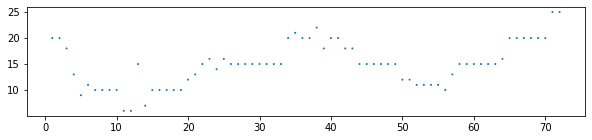

In [39]:
plt.figure(figsize=(10, 2))
plt.scatter(np.arange(len(intervalList)), intervalList, s=intervalList>0)
plt.show()

### 출차 시간을 그래프에 찍어본다.

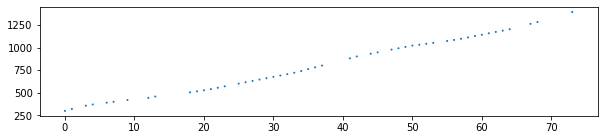

In [40]:
'''
01. 데이터프레임의 행 하나(시리즈)를 가져온다.
02. 시리즈의 각 데이터에서 기준시간, 조사일의 자정(00시)),을 빼서 timedelta 타입으로 변환한다.
'''
isShowInfo = True

# 1.
datetimeArr = oneDay_df.iloc[0]

# 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.
sampleTime = np.datetime64(todayDateTimeStr)
timedeltaArr = datetimeArr - sampleTime
timedeltaSeries = pd.Series(timedeltaArr)
totalSecondsSeries = timedeltaSeries.dt.total_seconds()
totalSecondsSeries /= 60
totalSecondsSeries

plt.figure(figsize=(10, 2))
plt.scatter(np.arange(len(totalSecondsSeries)), totalSecondsSeries, s=totalSecondsSeries>0)
plt.show()

In [41]:
sampleTime

numpy.datetime64('2020-12-28')

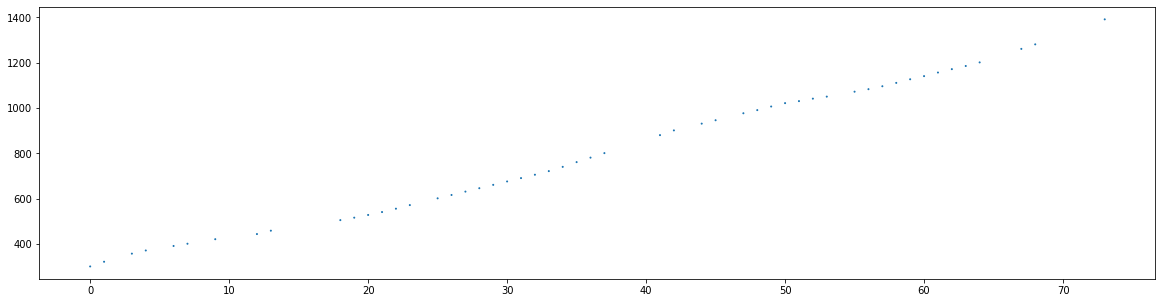

In [48]:
'''
01. 데이터프레임의 행 하나(시리즈)를 가져온다.
02. 시리즈의 각 데이터에서 기준시간, 조사일의 자정(00시)),을 빼서 timedelta 타입으로 변환한다.
'''
plt.figure(figsize=(20, 5))

for i in range(1):
    # 1.
    datetimeArr = oneDay_df.iloc[i]

    # 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.
    sampleTime = np.datetime64(todayDateTimeStr)
    timedeltaArr = datetimeArr - sampleTime
    timedeltaSeries = pd.Series(timedeltaArr)
    totalSecondsSeries = timedeltaSeries.dt.total_seconds()
    totalSecondsSeries /= 60
    totalSecondsSeries

    plt.scatter(np.arange(len(totalSecondsSeries)), totalSecondsSeries, s=totalSecondsSeries>0)
plt.show()

In [43]:
hours = newTimedeltaSeries//3600
minutes = round(newTimedeltaSeries/60 - (hours)*60)
for h, m in zip(hours, minutes):
    try:
        print(int(h), int(m), sep=':')
    except:
        print('nan')

5:3
5:23
5:43
6:1
6:13
6:22
6:33
6:43
6:53
7:3
7:13
7:19
7:26
7:41
7:48
7:58
8:8
8:18
8:28
8:38
8:50
9:3
9:18
9:34
9:48
10:4
10:18
10:33
10:48
11:3
11:18
11:33
11:48
12:3
12:23
12:43
13:3
13:23
13:45
14:3
14:23
14:43
15:0
15:18
15:33
15:48
16:3
16:18
16:33
16:48
17:0
17:13
17:24
17:34
17:45
17:55
18:5
18:18
18:33
18:48
19:3
19:18
19:33
19:48
20:4
20:23
20:43
21:3
21:23
21:43
22:3
22:28
22:53
nan


In [44]:
newDatetimeSeries = pd.to_datetime(newTimedeltaSeries, unit='s')
newDatetimeSeries = newDatetimeSeries.dt.strftime('%Y-%m-%d %H:%M:%S')
pd.DataFrame(newDatetimeSeries).transpose()

,경기70아8789_0,경기70아6926_0,경기70아7482_0,경기78아1147_0,경기78아1117_0,경기70아7361_0,경기77바1097_0,경기70아8880_0,경기70아8601_0,경기70아8629_0,경기76사5089_0,경기70아7474_0,경기77바1198_0,경기70아8789_106,강원71바1297_0,경기70아6926_90,경기70아7482_99,경기78아1117_106,경기78아1147_100,경기70아7361_116,경기77바1097_108,경기70아8880_111,경기70아8601_112,경기70아7474_78,경기70아8629_110,경기77바1198_118,경기70아8789_216,경기70아6926_195,경기70아7482_203,경기78아1117_200,경기70아7361_224,경기78아1147_196,경기77바1097_204,경기70아8880_197,경기70아8601_220,경기70아7474_169,경기70아8629_199,경기77바1198_235,경기70아8789_313,경기70아6926_293,경기70아7482_304,경기78아1147_286,경기78아1117_295,경기70아7361_317,경기77바1097_302,경기70아8880_308,경기70아8601_318,경기78아1178_0,경기70아8629_296,경기77바1198_350,경기70아8789_420,경기70아6926_391,경기70아7482_418,경기78아1147_383,경기78아1117_388,경기70아7361_416,경기77바1097_412,경기70아8880_421,경기70아8601_428,경기78아1178_110,경기70아8629_404,경기77바1198_470,경기70아8789_540,경기70아6926_505,경기70아7482_540,경기78아1147_507,경기78아1117_499,경기70아7361_526,경기77바1097_523,경기70아8880_527,경기70아8601_538,경기78아1178_210,경기70아8629_499,경기77바1198_563
3,1970-01-01 05:02:58,1970-01-01 05:22:47,1970-01-01 05:42:38,1970-01-01 06:00:31,1970-01-01 06:13:26,1970-01-01 06:22:23,1970-01-01 06:33:19,1970-01-01 06:43:15,1970-01-01 06:53:12,1970-01-01 07:03:07,1970-01-01 07:13:03,1970-01-01 07:19:29,1970-01-01 07:25:55,1970-01-01 07:40:49,1970-01-01 07:47:46,1970-01-01 07:57:38,1970-01-01 08:07:33,1970-01-01 08:17:47,1970-01-01 08:28:01,1970-01-01 08:38:16,1970-01-01 08:50:12,1970-01-01 09:03:04,1970-01-01 09:17:54,1970-01-01 09:33:45,1970-01-01 09:47:39,1970-01-01 10:03:32,1970-01-01 10:18:23,1970-01-01 10:33:18,1970-01-01 10:48:11,1970-01-01 11:03:05,1970-01-01 11:18:02,1970-01-01 11:32:54,1970-01-01 11:47:48,1970-01-01 12:02:41,1970-01-01 12:22:32,1970-01-01 12:43:22,1970-01-01 13:03:14,1970-01-01 13:23:04,1970-01-01 13:44:54,1970-01-01 14:02:48,1970-01-01 14:22:40,1970-01-01 14:42:32,1970-01-01 15:00:25,1970-01-01 15:18:19,1970-01-01 15:33:16,1970-01-01 15:48:10,1970-01-01 16:03:05,1970-01-01 16:18:00,1970-01-01 16:32:53,1970-01-01 16:47:49,1970-01-01 17:00:12,1970-01-01 17:12:36,1970-01-01 17:23:32,1970-01-01 17:34:07,1970-01-01 17:44:43,1970-01-01 17:55:19,1970-01-01 18:05:17,1970-01-01 18:18:13,1970-01-01 18:33:07,1970-01-01 18:48:00,1970-01-01 19:02:54,1970-01-01 19:17:49,1970-01-01 19:32:43,1970-01-01 19:47:38,1970-01-01 20:03:32,1970-01-01 20:23:25,1970-01-01 20:43:19,1970-01-01 21:03:13,1970-01-01 21:23:06,1970-01-01 21:43:00,1970-01-01 22:02:55,1970-01-01 22:27:45,1970-01-01 22:52:36,NaN


### curve-fit test

In [57]:
#데이터 확인
datetimeArr = oneDay_df.iloc[1]

# 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.
sampleTime = np.datetime64(todayDateTimeStr)
timedeltaArr = datetimeArr - sampleTime
timedeltaSeries = pd.Series(timedeltaArr)
totalSecondsSeries = timedeltaSeries.dt.total_seconds()
totalSecondsSeries /= 60
pd.DataFrame(totalSecondsSeries).transpose().isnull()

# plt.scatter(np.arange(len(totalSecondsSeries)), totalSecondsSeries, s=totalSecondsSeries>0)

,경기70아8789_0,경기70아6926_0,경기70아7482_0,경기78아1147_0,경기78아1117_0,경기70아7361_0,경기77바1097_0,경기70아8880_0,경기70아8601_0,경기70아8629_0,경기76사5089_0,경기70아7474_0,경기77바1198_0,경기70아8789_106,강원71바1297_0,경기70아6926_90,경기70아7482_99,경기78아1117_106,경기78아1147_100,경기70아7361_116,경기77바1097_108,경기70아8880_111,경기70아8601_112,경기70아7474_78,경기70아8629_110,경기77바1198_118,경기70아8789_216,경기70아6926_195,경기70아7482_203,경기78아1117_200,경기70아7361_224,경기78아1147_196,경기77바1097_204,경기70아8880_197,경기70아8601_220,경기70아7474_169,경기70아8629_199,경기77바1198_235,경기70아8789_313,경기70아6926_293,경기70아7482_304,경기78아1147_286,경기78아1117_295,경기70아7361_317,경기77바1097_302,경기70아8880_308,경기70아8601_318,경기78아1178_0,경기70아8629_296,경기77바1198_350,경기70아8789_420,경기70아6926_391,경기70아7482_418,경기78아1147_383,경기78아1117_388,경기70아7361_416,경기77바1097_412,경기70아8880_421,경기70아8601_428,경기78아1178_110,경기70아8629_404,경기77바1198_470,경기70아8789_540,경기70아6926_505,경기70아7482_540,경기78아1147_507,경기78아1117_499,경기70아7361_526,경기77바1097_523,경기70아8880_527,경기70아8601_538,경기78아1178_210,경기70아8629_499,경기77바1198_563
2,False,True,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,False,False,True,False,False,False,False,True,True,True,True,True,False,True,False,False,False,False,True,False,True,False


### * Python을 활용한 Model fitting하기
https://smlee729.github.io/python/simulation/2015/03/25/2-curve_fitting.html

In [110]:
# y=ax+b를 리턴합니다.
def func(x, a, b):
    return a*x + b

In [111]:
x = np.linspace(0, 10, 100) #0에서 10까지 100개의 구간으로 나눕니다.

In [130]:
y = func(x, 1, 2)

In [121]:
popt, pcov = curve_fit(func, x, yn)

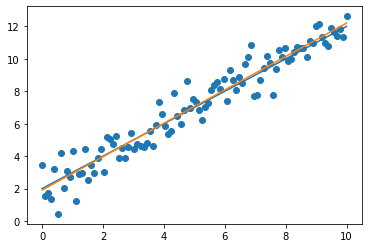

In [129]:
np.random.seed(1)
yn = y + 0.9*np.random.normal(size=len(x))

plt.plot(x, y)
plt.plot(x, func(x, *popt))
plt.scatter(x, yn)
plt.show()

## 시간별 첫차 시간표를 작성한다.

In [ ]:
"""
시간(hour)을 기준으로 데이터프레임의 열(column)을 세우고 출차 시간(minute)을 기록한 데이터 프레임을 반환한다.
열의 수: 첫차 시간(예: 05시) 부터 막차 시간(예: 23시) 까지 시간(hour)의 수, 예: 23 - 5 + 1, 19열
행의 수: 시간당 최대 배차 수
"""

## datetime을 string으로 형변환한다

In [ ]:
# datetime 객체를 string 객체로 변환합니다. 시간을 가지고 계산해야 하는 일은 이전에 실행하세요.
oneDayString_df = oneDay_df.astype('string')
for column in oneDayString_df.columns:
    oneDayString_df[column] = oneDayString_df[column].str.slice(start=10, stop=16)
# print(oneDayString_df.shape)
    
# [column명 : 차량번호] station_df 와 oneDay_df를 합칩니다. datetime이 아닌 다른 타입의 오브젝트가 행에 붙게 되므로 지금부터는 편집이 어렵습니다.
_finalOneDay_df = pd.concat([station_df,oneDayString_df], axis=1)
_finalOneDay_df.set_index('stationSeq', drop=True, inplace=True)
_finalOneDay_df.shape

In [ ]:
# 정렬된 column에 출차 순서를 배정합니다. (1호차, 2호차, ...)
oneDayString_df.columns = oneDayString_df.columns

In [ ]:
# [column명 : n호차] station_df 와 oneDay_df를 합칩니다. datetime이 아닌 다른 타입의 오브젝트가 행에 붙게 되므로 지금부터는 편집이 어렵습니다.
finalOneDay_df = pd.concat([station_df,oneDayString_df], axis=1)
df = finalOneDay_df.set_index('stationSeq', drop=True)

In [ ]:
html = df.to_html()
# writedata.py
f = open("test.html", 'w')

f.write(html)
f.close()

In [ ]:
for i in range(len(station_df)):
    location = (station_df.iloc[i]['y'], station_df.iloc[i]['x'])
    stationName = station_df.iloc[i]['stationName']
#     print("{content: '<div>", stationName, "</div>',latlng: new kakao.maps.LatLng", location, "},", sep="")

## 일일 시간표 데이터 csv로 내보내기

In [ ]:
rootPath = 'C:/Users/jongh/OneDrive/School/석사/1-2/자료구조/프로젝트/5.DATA/Master/dataAPI/DailyTimeTable/' + str(routeId)
createFolder(rootPath)
outputPath = rootPath + '/' + str(routeId) + '_' + str(year)[-2:] + '-' + str(month) + '-' + str(day) + '.csv'
df.to_csv(outputPath)

# CSV 파일을 읽어서 EXCEL파일로 내보낸다 : 블로그 게시 목적

## 일일 시간표 데이터 csv 읽어오기

In [ ]:
df = pd.read_csv(outputPath)

## 노선번호 받아오기

In [ ]:
KEY = 'yEaR%2F3MDedRSlVJL%2F2pxnVg0yre1N5VF3RZ%2FUAt56MJ7J2mNpfqhUvy05pXV0uhHTVY7DbyCR8xmMaDdYga67Q%3D%3D' # 종현
apiKey = unquote(KEY)

# 노선정보항목조회 busrouteservice/info
# 해당 노선에 대한 노선번호, 기점/종점 정류소, 첫차/막차시간, 배차간격, 운행업체 등의 운행계획 정보를 제공합니다.
url = 'http://openapi.gbis.go.kr/ws/rest/busrouteservice/info'
queryParams = '?' + urlencode({ quote_plus('serviceKey') : apiKey, quote_plus('routeId') : routeId })
# print(url+queryParams)

request = Request(url + queryParams)
request.get_method = lambda: 'GET'
oneLineXML = urlopen(request).read().decode('utf8')
# print(oneLineXML)

xtree = ET.fromstring(oneLineXML)
resultCode = int(xtree[1].find("resultCode").text)
msgBody = xtree[2]

busRouteInfoItem = msgBody[0]
i=0
for info in busRouteInfoItem:
    print(f"{i} {info.tag} : {info.text}")
    i+=1

In [ ]:
routeName = busRouteInfoItem.find("routeName").text

## Excel로 내보내기

In [ ]:
rootPath = 'C:/Users/jongh/OneDrive/School/석사/1-2/자료구조/프로젝트/5.DATA/Master/dataAPI/ExcelExport/'
excelFileName = str(routeName) + '.xlsx'
filePath = rootPath + excelFileName

createFolder(rootPath)
print(filePath)

### 배포용 DataFrame 수정

In [ ]:
export_df = df.set_index('stationName').drop('stationId', axis=1)

### 내보내기

In [ ]:
#-- write an object to an Excel sheet using pd.DataFrame.to_excel()
export_df.to_excel(filePath, # directory and file name to write
            sheet_name = '평일', 
            na_rep = 'NaN', 
            float_format = "%.2f", 
            header = True, 
            #columns = ["group", "value_1", "value_2"], # if header is False
            index = True, 
            index_label = "정류장", 
            startrow = 0, 
            startcol = 0, 
            engine = 'openpyxl', 
            freeze_panes = (1, 1)
            )

## Excel 접근하여 수정하기
https://naakjii.tistory.com/56

In [ ]:
wb = openpyxl.load_workbook(filePath)
sheet = wb['평일']

In [ ]:
sheet.max_column, sheet.max_row

In [ ]:
sheet.column_dimensions['A'].width = 14

In [ ]:
for cell in sheet['A']:
    cell.alignment = openpyxl.styles.Alignment(horizontal='left', vertical='center')
#     cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=openpyxl.styles.colors.Color(rgb='00FF00'))

In [ ]:
wb.save(filePath)

In [ ]:
wb.close()